In [6]:
import os
from pathlib import Path

current_path = os.getcwd()
DATA_PATH = Path(current_path).parent / 'data'
RESULT_PATH = Path(current_path).parent / 'results'
assert DATA_PATH.exists() and RESULT_PATH.exists()

from IPython import display
from pathlib import Path
from typing import List, Union

import albumentations as A
import mml.api as mml
import mml.api.interactive as api
import numpy as np
import plotly.graph_objects as go
import plotly.subplots

mml_env_path = Path(os.getcwd()).parent / 'mml.env'
api.init(mml_env_path)

MML API already initialized.


In [3]:
all_tasks = ['lapgyn4_surgical_actions', 'lapgyn4_instrument_count', 'lapgyn4_anatomical_actions', 'nerthus_bowel_cleansing_quality', 'hyperkvasir_therapeutic-interventions', 'cholec80_grasper_presence', 'cholec80_hook_presence', 'idle_action_recognition', 'brain_tumor_classification', 'brain_tumor_type_classification', 'chexpert_enlarged_cardiomediastinum', 'chexpert_cardiomegaly', 'chexpert_edema', 'chexpert_consolidation', 'chexpert_pneumonia', 'chexpert_pneumothorax', 'chexpert_pleural_effusion', 'chexpert_fracture', 'pneumonia_classification', 'covid_xray_classification', 'deep_drid_dr_level', 'deep_drid_quality', 'kvasir_capsule_anatomy', 'mura_xr_wrist', 'mura_xr_shoulder', 'mura_xr_humerus', 'mura_xr_hand', 'mura_xr_forearm', 'mura_xr_finger', 'mura_xr_elbow']

In [4]:
def plot_sample_grid(task_list: List[str], result_path: Path, proportion: float = 11 / 5,
                     sort_by: str = 'size') -> go.Figure:
    # gather infos
    task_infos = api.get_task_infos(task_list=task_list)
    # gather sample images
    imgs = {}
    with api.default_file_manager() as fm:
        for task in task_list:
            ds = mml.TaskDataset(root=fm.data_path / fm.task_index[task]['none'], split=mml.DataSplit.TRAIN, fold=0,
                                 caching_limit=0,
                                 transform=A.Compose(
                                     [A.SmallestMaxSize(max_size=256), A.PadIfNeeded(min_height=288, min_width=288),
                                      A.Resize(height=256, width=256)]))
            imgs[task] = ds[-1]['image']
    n_rows = int(np.sqrt(len(task_list) * proportion))
    n_cols = int(np.ceil(len(task_list) / n_rows).item())

    def sort_func(task: str) -> Union[str, float, int]:
        if sort_by == 'size':
            return task_infos.num_samples[task]
        elif sort_by == 'alphabetic':
            return task
        elif sort_by == 'classes':
            return task_infos.num_classes[task]
        elif sort_by == 'domains':
            return str(task_infos.domains[task].value)
        elif sort_by == 'ir':
            return task_infos.imbalance_ratios[task]
        else:
            raise ValueError(f'{sort_by} not a valid sort method')

    sorted_tasks = sorted(task_list, key=sort_func)
    fig = plotly.subplots.make_subplots(rows=n_rows, cols=n_cols, shared_yaxes='all', shared_xaxes='all',
                                        horizontal_spacing=0.01, vertical_spacing=0.05,
                                        subplot_titles=[f"<b><span style='color:red'>{task_infos.num_samples[task]/1000:.1f}k</span>  <span style='color:green'>{task_infos.num_classes[task]}</span>  <span style='color:blue'>{task_infos.imbalance_ratios[task]:.1f}</span></b>" for task in sorted_tasks],
                                        )
    fig.update_annotations(font_size=30, font_color='black', bgcolor='white')
    for idx, task in enumerate(sorted_tasks):
        row, col = divmod(idx, n_cols)
        fig.add_trace(go.Image(z=imgs[task]), row=row + 1, col=col + 1, )
    fig.update_layout(autosize=False, width=1800, height=600)
    fig.update_layout(margin=dict(l=10, r=10, b=10, t=30, pad=15), paper_bgcolor='white', plot_bgcolor='white')
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig['layout']['font']['family'] = "NewComputerModern10"
    fig.write_html(result_path / f'sample_grid_{sort_by}.html')
    fig.write_image(result_path / f'sample_grid_{sort_by}.png')
    fig.write_image(result_path / f'sample_grid_{sort_by}.eps')
    return fig

In [5]:
_ = plot_sample_grid(task_list=all_tasks, result_path=RESULT_PATH, proportion=3/10, sort_by='ir')

## Figure 2

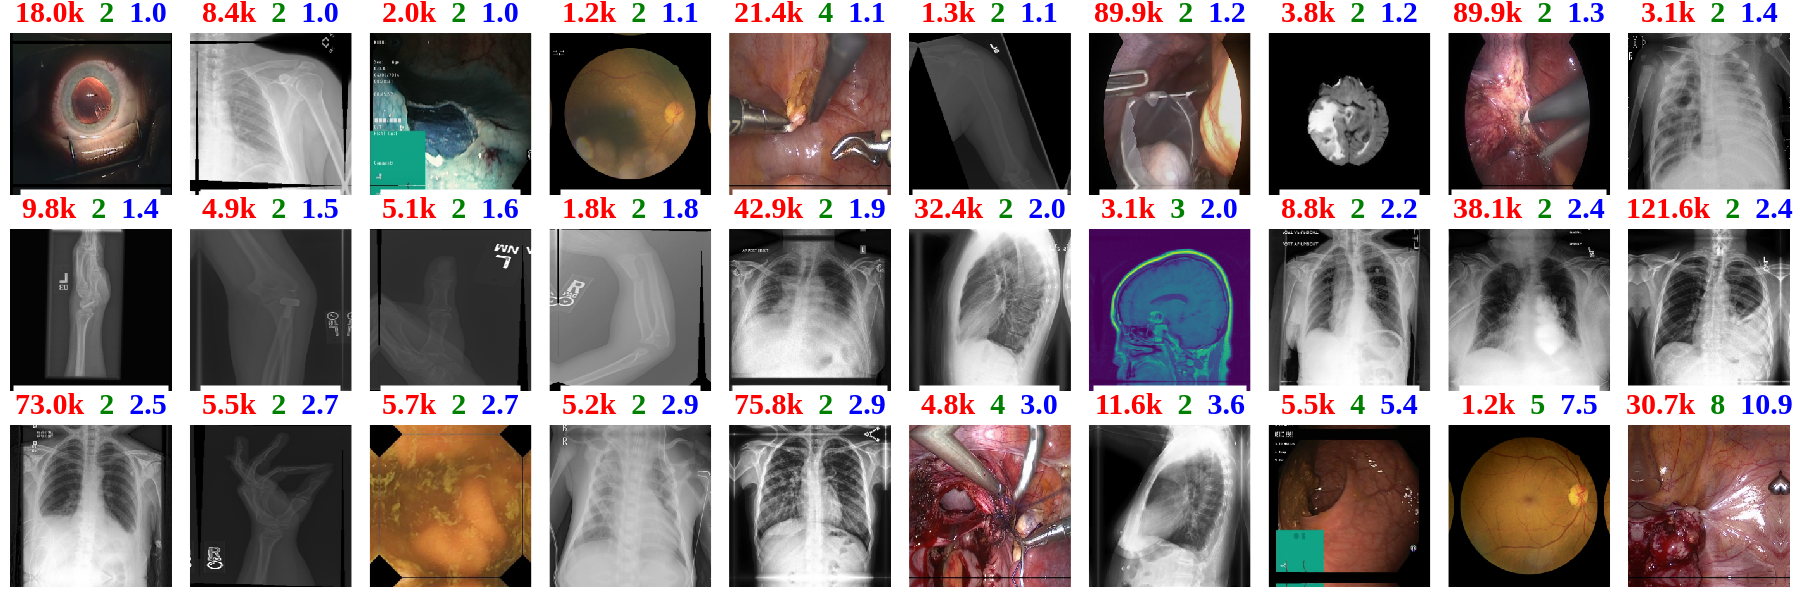

In [8]:
display.Image(RESULT_PATH / 'sample_grid_ir.png')